<a href="https://colab.research.google.com/github/keropfia/Primary-models/blob/main/Trial%20for%20fun%202-works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.4 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from lmfit import Model

In [11]:
df = pd.read_excel("B. cereus growth data.xlsx")
print(df)

    Time (h)      Rep1      Rep2      Rep3
0          0  3.982365  3.827031  3.911132
1          4  3.846654  3.763745  3.932556
2          8  3.963752  3.930527  3.918763
3         12  3.520305  3.927485  3.788320
4         16  3.969261  3.861798  3.770790
5         20  3.930336  3.849437  3.980016
6         24  4.429522  4.523595  4.414396
7         28  4.277665  4.385004  4.305009
8         32  5.173528  5.226381  5.125501
9         36  5.016071  4.831717  4.909100
10        40  5.611515  5.624286  5.641800
11        44  5.581323  5.643726  5.676382
12        48  6.577803  6.559915  6.654384
13        56  6.892184  6.846321  6.935704
14        64  7.758486  7.522454  7.654999
15        72  7.429599  7.425471  7.434580


In [12]:
replicate_cols = ['Rep1', 'Rep2', 'Rep3']

In [13]:
df['Mean'] = df[replicate_cols].mean(axis=1)
df['Std'] = df[replicate_cols].std(axis=1)

In [14]:
df['Time (h)'] = pd.to_numeric(df['Time (h)'], errors='coerce')
df = df.dropna(subset=['Time (h)', 'Mean'])

In [15]:
def baranyi_log10(x, logN0_baranyi, logN_max_baranyi, mu_baranyi, lambda_baranyi):
    x = np.array(x)
    numerator = -1 + np.exp(mu_baranyi * lambda_baranyi) + np.exp(mu_baranyi * x)
    denominator = -1 + np.exp(mu_baranyi * x) + np.exp(mu_baranyi * lambda_baranyi) * 10**(logN_max_baranyi - logN0_baranyi)
    f = logN_max_baranyi + np.log10(numerator / denominator)
    return f

In [16]:
model = Model(baranyi_log10)

In [19]:
params = model.make_params(
    logN0_baranyi=df['Mean'].min(),
    logN_max_baranyi=df['Mean'].max(),
    mu_baranyi=0.5,
    lambda_baranyi=1
    )

In [20]:
params['logN0_baranyi'].min = 0
params['logN_max_baranyi'].min = df['Mean'].min()
params['mu_baranyi'].min = 1e-6
params['lambda_baranyi'].min = 0

In [21]:
result = model.fit(df['Mean'], params, x=df['Time (h)'])

In [22]:
print(result.fit_report())

[[Model]]
    Model(baranyi_log10)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 16
    # variables        = 4
    chi-square         = 0.58011134
    reduced chi-square = 0.04834261
    Akaike info crit   = -45.0739833
    Bayesian info crit = -41.9836284
    R-squared          = 0.97932693
[[Variables]]
    logN0_baranyi:     3.83877332 +/- 0.10569037 (2.75%) (init = 3.74537)
    logN_max_baranyi:  7.59808129 +/- 0.20882278 (2.75%) (init = 7.645313)
    mu_baranyi:        0.22616815 +/- 0.02414971 (10.68%) (init = 0.5)
    lambda_baranyi:    22.4709642 +/- 2.62650153 (11.69%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu_baranyi, lambda_baranyi)       = +0.8206
    C(logN0_baranyi, lambda_baranyi)    = +0.7048
    C(logN_max_baranyi, mu_baranyi)     = -0.4105
    C(logN0_baranyi, mu_baranyi)        = +0.3380
    C(logN_max_baranyi, lambda_baranyi) = -0.2612
    C(logN0_baranyi, logN_max_baranyi)  

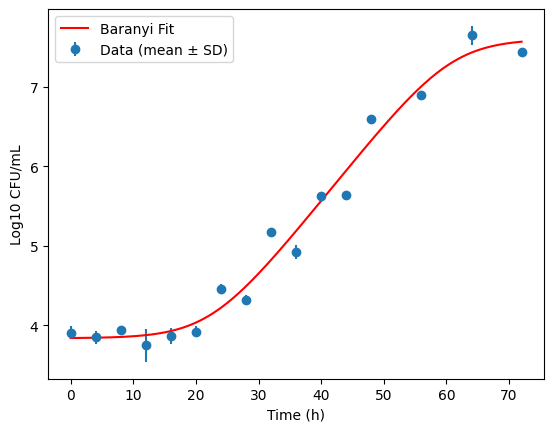

In [26]:
time_fine = np.linspace(df['Time (h)'].min(), df['Time (h)'].max(), 200)
fit_fine = result.eval(x=time_fine)  # Evaluate the fitted model at finer points

plt.errorbar(df['Time (h)'], df['Mean'], yerr=df['Std'], fmt='o', label='Data (mean ± SD)')
plt.plot(time_fine, fit_fine, 'r-', label='Baranyi Fit')
plt.xlabel('Time (h)')
plt.ylabel('Log10 CFU/mL')
plt.legend()
plt.show()

In [24]:
logN0_fit = result.params['logN0_baranyi'].value
logNmax_fit = result.params['logN_max_baranyi'].value
mumax_fit = result.params['mu_baranyi'].value
lambda_fit = result.params['lambda_baranyi'].value

print(f"Fitted parameters:")
print(f"logN0 = {logN0_fit:.2f}")
print(f"logNmax = {logNmax_fit:.2f}")
print(f"mu_max = {mumax_fit:.3f}")
print(f"lag phase (lambda) = {lambda_fit:.2f} hours")

Fitted parameters:
logN0 = 3.84
logNmax = 7.60
mu_max = 0.226
lag phase (lambda) = 22.47 hours
